# Logistic Regression
In this notebook, I implement Logistic Regression (LR) and the Recursive Formulation of Logistic Regression (RFLR) as mentioned in the Beron 2023 paper.

    Beron, C. C., Neufeld, S. Q., Linderman, S. W., & Sabatini, B. L. (2022). Mice exhibit stochastic and efficient action switching during probabilistic decision making. Proceedings of the National Academy of Sciences, 119(15), e2113961119. https://doi.org/10.1073/pnas.2113961119


In [1]:
from src import rnn_utils
from src import switch_utils
from src import lr
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import jax
import jax.numpy as jnp
import haiku as hk

DatasetRNN = rnn_utils.DatasetRNN

In [2]:
data_dir = '/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/data/processed'
model_dir = "/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/models/"

train_prop = 0.7
cv = f'{train_prop*100:.0f}-{(1-train_prop)*100:.0f}'
split_dt = "2025-04-17_10-28"
batch_size = 64

df_tr = pd.read_csv(os.path.join(data_dir, f"train_df_{cv}_{split_dt}.csv"))
df_va = pd.read_csv(os.path.join(data_dir, f"validation_df_{cv}_{split_dt}.csv"))

ds_tr = switch_utils.get_dataset(df_tr, batch_size)
ds_va = switch_utils.get_dataset(df_va, batch_size)


In [3]:
params, opt_state, losses = lr.train_gru_network(lr.vmap_forward_fn,
                                                ds_tr,
                                                ds_va,
                                                n_steps=1e4)

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
def log_likelihood_normalised(
      labels: np.ndarray, log_odds: np.ndarray
  ) -> float:
    # Mask any errors for which label is negative
    mask = jnp.logical_not(labels < 0)
    ps = jax.nn.log_softmax(log_odds)
    if labels.shape[2] != 1:
      raise ValueError(
          'Categorical loss function requires targets to be of dimensionality'
          ' (n_timesteps, n_episodes, 1)'
      )
    one_hot_labels = jax.nn.one_hot(labels[:, :, 0], num_classes=2)
    
    log_liks = one_hot_labels * ps
    masked_log_liks = jnp.multiply(log_liks, mask)
    loss = jnp.nansum(masked_log_liks)
    return loss / np.sum(mask)

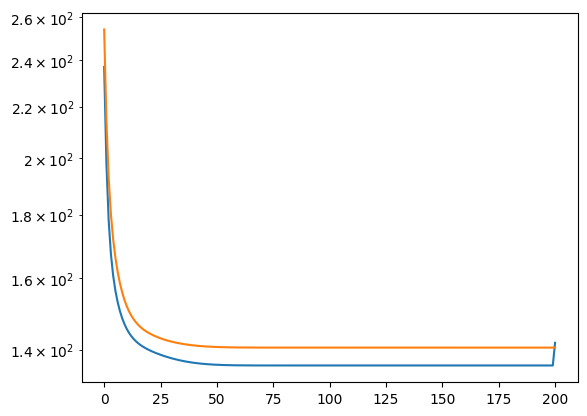

In [5]:
plt.semilogy(losses['training_loss'])
plt.semilogy(losses['validation_loss'])

In [6]:
lr_input, lr_output = lr.lr_window_fn(ds_tr._xs, ds_tr._ys)

model = hk.transform(lr.vmap_forward_fn)

output = model.apply(params, None, lr_input, output_dim=2)

# sample from the output either greedily or with thompson sampling
ll = log_likelihood_normalised(ds_tr._ys, output)
print(f"The log likelihood for logistic regression is {ll:.3f}.")

The log likelihood for logistic regression is -0.200.


In [ ]:

sample_type = 'thompson'
y_sampled = switch_utils.sampler(output, sample_type, key=69)
print(y_sampled.shape)

In [ ]:
# simulated conditional probability dictionary for each 3 letter history
p_dict = switch_utils.switch_bars(ds_tr._xs, ds_tr._xs[:,:,0], symm=True, prob=True)
sim_p_dict = switch_utils.switch_bars(ds_tr._xs[4:], y_sampled, symm=True, prob=True)

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_keys = [item[0] for item in sorted_items] 
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
sim_sorted_heights = [sim_p_dict[key] for key in sorted_keys]

sns.set(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sim_sorted_heights, color='g', alpha=1, ax=ax, label='DisRNN Switch Prob')
sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray', label='Mouse Switch Prob')

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.title('Conditional Switch Probabilities')
plt.tight_layout()
plt.legend()
# plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/switch_probs.pdf')
plt.show()